# t-SNE plots 
```shell
conda install anaconda::scikit-learn
```

In [1]:
from dataset_analysis.lib.tSEN_utils import merg_tSNE
import pandas as pd
import os
from dataset_analysis.lib.tSEN_utils import show_tSNE
from dataset_analysis.lib.tSEN_utils import sampling, omit_outline

base_path = './result/dataset_analysis'
number_vector = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

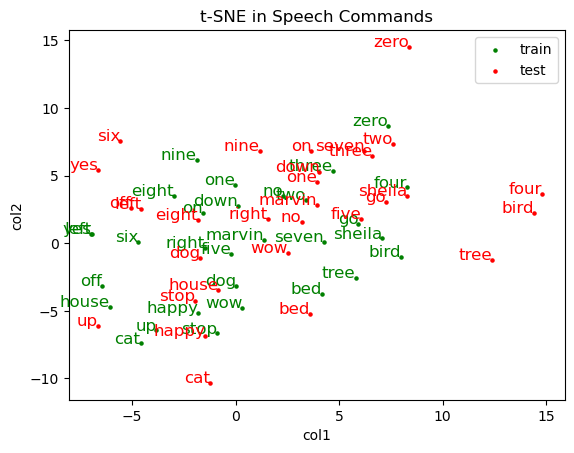

In [2]:
sc_full = pd.read_csv(os.path.join(base_path, 'speech-commands', 'speech-commands_full_tsen.csv'))
sc_train = sc_full[sc_full['source'] == 'train']
sc_test = sc_full[sc_full['source'] == 'test']
sc_train = merg_tSNE(df=sc_train, mode='mean')
sc_test = merg_tSNE(df=sc_test, mode='mean')
# sc_train = sc_train[sc_train['label'].isin(number_vector)]
# sc_test = sc_test[sc_test['label'].isin(number_vector)]
show_tSNE(title='t-SNE in Speech Commands', train_df=sc_train, test_df=sc_test)

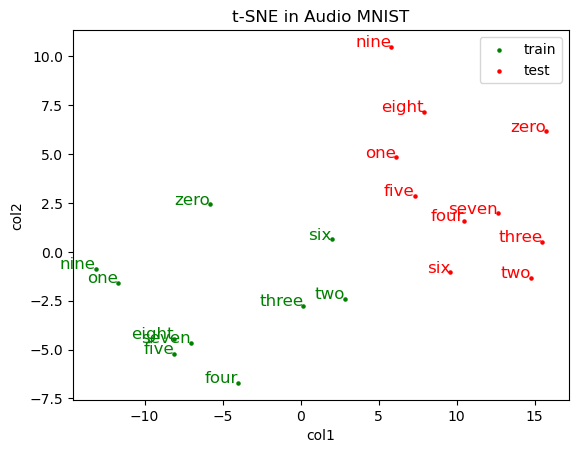

In [3]:
mnist_full = pd.read_csv(os.path.join(base_path, 'audio-mnist', 'audio-mnist_full_tsen.csv'))
mnist_train = mnist_full[mnist_full['source'] == 'train']
mnist_test = mnist_full[mnist_full['source'] == 'test']
mnist_train = merg_tSNE(df=mnist_train, mode='mean')
mnist_test = merg_tSNE(df=mnist_test, mode='mean')
show_tSNE(title='t-SNE in Audio MNIST', train_df=mnist_train, test_df=mnist_test)

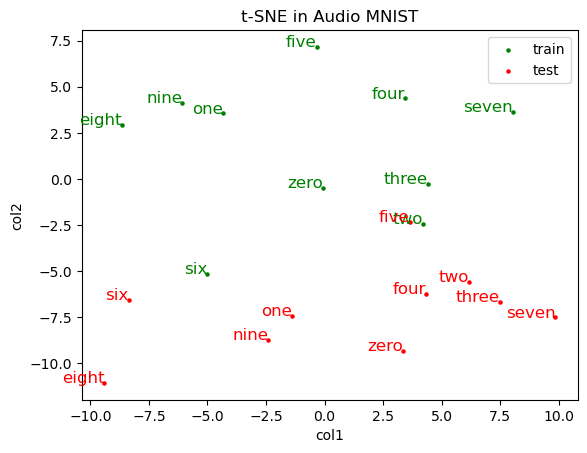

In [4]:
mnist_full = pd.read_csv(os.path.join(base_path, 'audio-mnist', 'audio-mnist_full_noreduced_tsen.csv'))
mnist_train = mnist_full[mnist_full['source'] == 'train']
mnist_test = mnist_full[mnist_full['source'] == 'test']
mnist_train = merg_tSNE(df=mnist_train, mode='mean')
mnist_test = merg_tSNE(df=mnist_test, mode='mean')
show_tSNE(title='t-SNE in Audio MNIST', train_df=mnist_train, test_df=mnist_test)

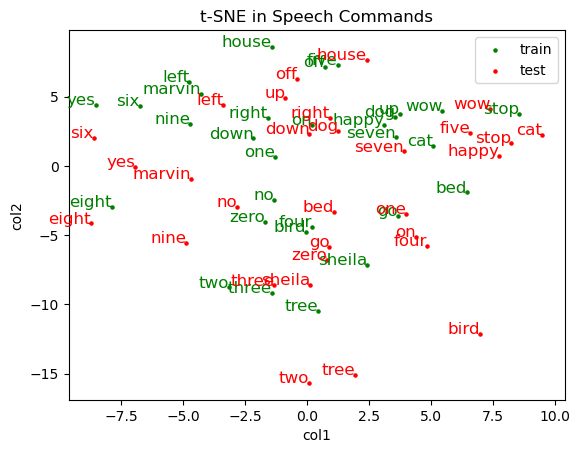

In [5]:
sc_full = pd.read_csv(os.path.join(base_path, 'speech-commands', 'speech-commands_full_noreduced_tsen.csv'))
sc_train = sc_full[sc_full['source'] == 'train']
sc_test = sc_full[sc_full['source'] == 'test']
sc_train = merg_tSNE(df=sc_train, mode='mean')
sc_test = merg_tSNE(df=sc_test, mode='mean')
# sc_train = sc_train[sc_train['label'].isin(number_vector)]
# sc_test = sc_test[sc_test['label'].isin(number_vector)]
show_tSNE(title='t-SNE in Speech Commands', train_df=sc_train, test_df=sc_test)

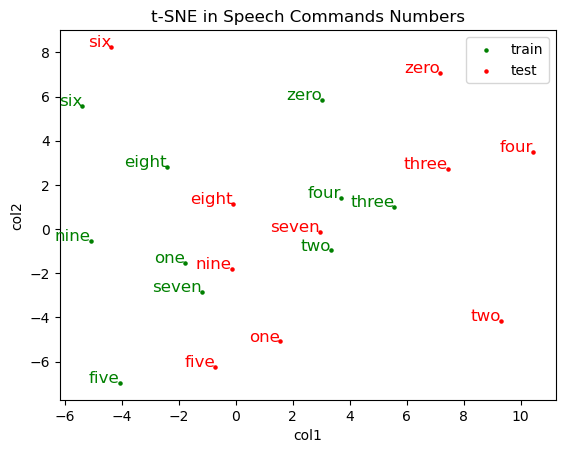

In [6]:
scn_full = pd.read_csv(os.path.join(base_path, 'speech-commands-numbers', 'speech-commands-numbers_full_noreduced_tsen.csv'))
scn_train = scn_full[scn_full['source'] == 'train']
scn_test = scn_full[scn_full['source'] == 'test']
scn_train = merg_tSNE(df=scn_train, mode='mean')
scn_test = merg_tSNE(df=scn_test, mode='mean')
show_tSNE(title='t-SNE in Speech Commands Numbers', train_df=scn_train, test_df=scn_test)

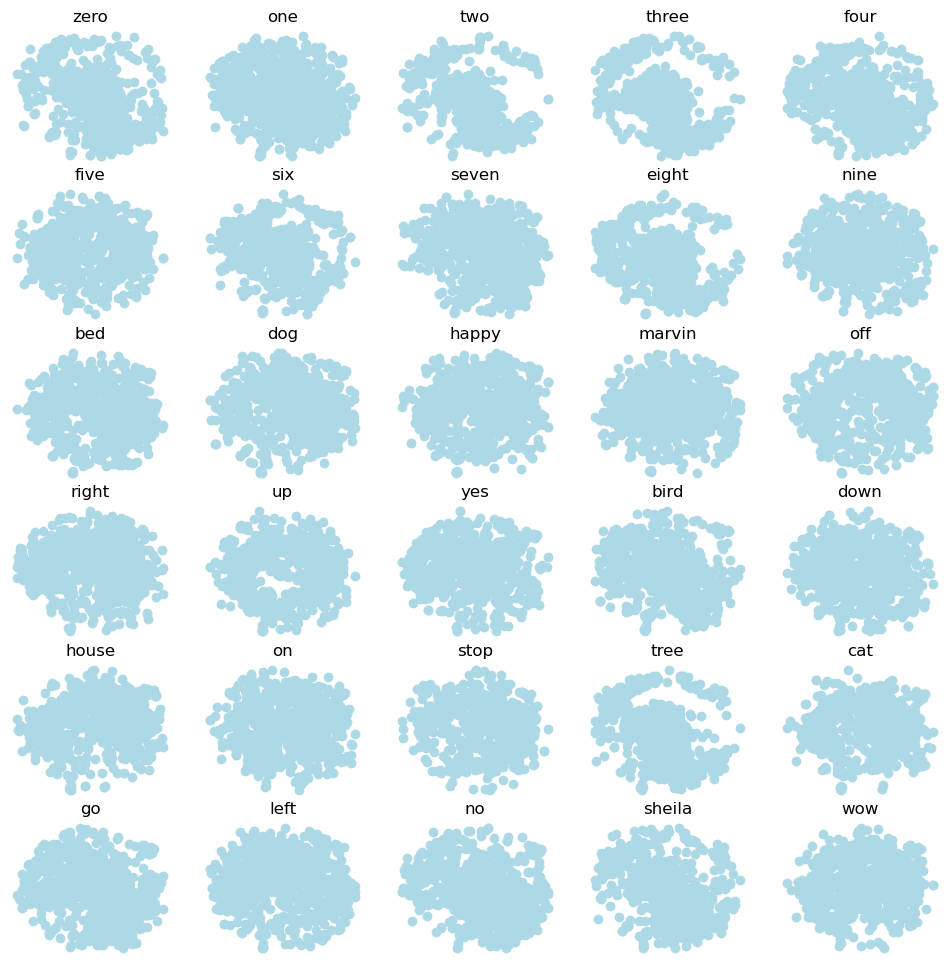

In [7]:
from dataset_analysis.lib.tSEN_utils import show_by_label
sc_full = pd.read_csv(os.path.join(base_path, 'speech-commands', 'speech-commands_full_noreduced_tsen.csv'))
sc_train = sc_full[sc_full['source'] == 'train']
sc_test = sc_full[sc_full['source'] == 'test']
show_by_label(df=sc_train)

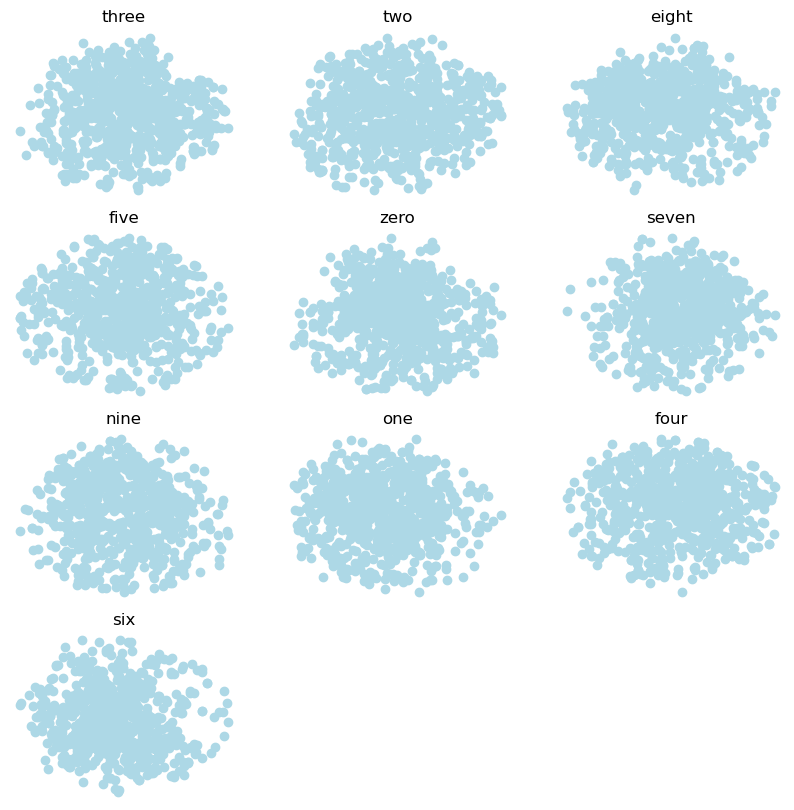

In [8]:
mnist_full = pd.read_csv(os.path.join(base_path, 'audio-mnist', 'audio-mnist_full_noreduced_tsen.csv'))
mnist_train = mnist_full[mnist_full['source'] == 'train']
mnist_test = mnist_full[mnist_full['source'] == 'test']
show_by_label(df=mnist_train, figheight=10, figwidth=10)

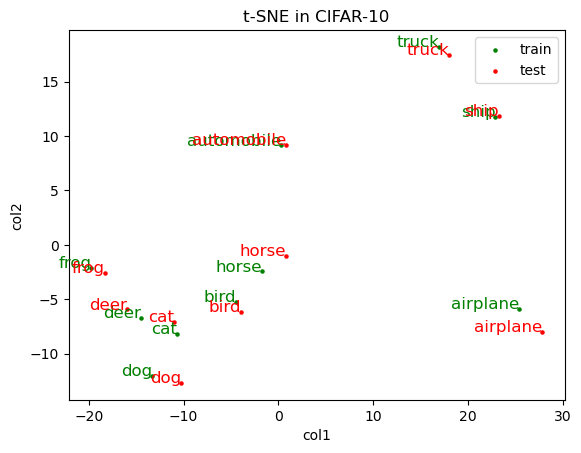

In [9]:
cifar_full = pd.read_csv(os.path.join(base_path, 'cifar-10', 'cifar-10_full_noreduced_tsen.csv'))
cifar_train = cifar_full[cifar_full['source'] == 'train']
cifar_test = cifar_full[cifar_full['source'] == 'test']
# cifar_train = omit_outline(df=cifar_train)
# cifar_train = sampling(df=cifar_train, max_size=20)
# cifar_test = omit_outline(df=cifar_test)
# cifar_test = sampling(df=cifar_test, max_size=20)
cifar_train = merg_tSNE(df=cifar_train)
cifar_test = merg_tSNE(df=cifar_test)
show_tSNE(title='t-SNE in CIFAR-10', train_df=cifar_train, test_df=cifar_test)